## 0. Basic

### Display the some first `image_file_names` & `file_name.csv`

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

## print out the names of the first 5 image_files (total = 10 images for train_imgaes & train_label_masks) with the train, test, submission.csv files & 5 file.hdf5
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:3]:
        print(os.path.join(dirname, filename))

/kaggle/input/pytable-hdf/img_dtbase_3750.h5
/kaggle/input/pytable-hdf/img_dtbase_10250.h5
/kaggle/input/pytable-hdf/img_dtbase_5000.h5
/kaggle/input/prostate-cancer-grade-assessment/train.csv
/kaggle/input/prostate-cancer-grade-assessment/test.csv
/kaggle/input/prostate-cancer-grade-assessment/sample_submission.csv
/kaggle/input/prostate-cancer-grade-assessment/train_images/eac2bfcf6b1dd7733ab9e2f31452e5bd.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/6ccb8529cc90ff30751eff7a1d055b6e.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/5f204e4117e261c6bfb06626e5bb2410.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/3e16a4a0816d8380163af60dfc884195_mask.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/3639415568d06af82c3cfcfeeae5d9b6_mask.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/466a84e8d13813e7aabfe440f437d990_mask.tiff
/kaggle/input/h5-files/full_data_coordinate.h5


## 1. Basic libraries

### Loading & viewing dataset

In [2]:
import os

import openslide
import skimage.io
import random
import seaborn as sns
import cv2

import matplotlib
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image, display

import plotly.graph_objs as go

BASE_PATH = '../input/prostate-cancer-grade-assessment'

data_dir = f'{BASE_PATH}/train_images'
mask_dir = f'{BASE_PATH}/train_label_masks'

train = pd.read_csv(f'{BASE_PATH}/train.csv').set_index('image_id')
test = pd.read_csv(f'{BASE_PATH}/test.csv')

train_labels = pd.read_csv('/kaggle/input/prostate-cancer-grade-assessment/train.csv').set_index('image_id')

submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

### 1. Create the `mutual_id_image` 

In the previous sesion, we have show that it concided to the `mask_dir`

Beside that, at each time we enter to the kernel, the arrangement of the img_id may be `changed`, so to fixed this for the partner, I will sort all of them before going on the tasks

In [3]:
id_dir = [name.replace('_mask.tiff', '') for name in os.listdir(mask_dir)]
id_dir.sort()
print(id_dir[:5])

id_dir.remove('3790f55cad63053e956fb73027179707')
img_id_mutual_name = id_dir
img_id_mutual_name[:5], len(img_id_mutual_name)

['0005f7aaab2800f6170c399693a96917', '000920ad0b612851f8e01bcc880d9b3d', '0018ae58b01bdadc8e347995b69f99aa', '001c62abd11fa4b57bf7a6c603a11bb9', '001d865e65ef5d2579c190a0e0350d8f']


(['0005f7aaab2800f6170c399693a96917',
  '000920ad0b612851f8e01bcc880d9b3d',
  '0018ae58b01bdadc8e347995b69f99aa',
  '001c62abd11fa4b57bf7a6c603a11bb9',
  '001d865e65ef5d2579c190a0e0350d8f'],
 10515)

In [4]:
import deepdish as dd

df = dd.io.load('/kaggle/input/h5-files/full_data_coordinate.h5')
len(df)//36, len(df[0]), df[0]

(9790, 5, ['0005f7aaab2800f6170c399693a96917', 13312, 13824, 7168, 7680])

In [5]:
def load_data_and_mask(ID, coordinates, level = 1):
    """
    
    """
    data_img = skimage.io.MultiImage(os.path.join(data_dir, f'{ID}.tiff'))[level]
    mask_img = skimage.io.MultiImage(os.path.join(mask_dir, f'{ID}_mask.tiff'))[level]
    coordinates = [coordinate // 2**(2*level) for coordinate in coordinates]
    data_tile = data_img[coordinates[0]: coordinates[1], coordinates[2]: coordinates[3], :]
    mask_tile = mask_img[coordinates[0]: coordinates[1], coordinates[2]: coordinates[3], :]
    data_tile = cv2.resize(data_tile, (512, 512))
    mask_tile = cv2.resize(mask_tile, (512, 512))
    del data_img, mask_img
    
    # Load and return small image
    return data_tile, mask_tile

CPU times: user 1.22 s, sys: 451 ms, total: 1.67 s
Wall time: 1.72 s
CPU times: user 92.5 ms, sys: 25.4 ms, total: 118 ms
Wall time: 121 ms
CPU times: user 15.2 ms, sys: 964 µs, total: 16.2 ms
Wall time: 16.4 ms


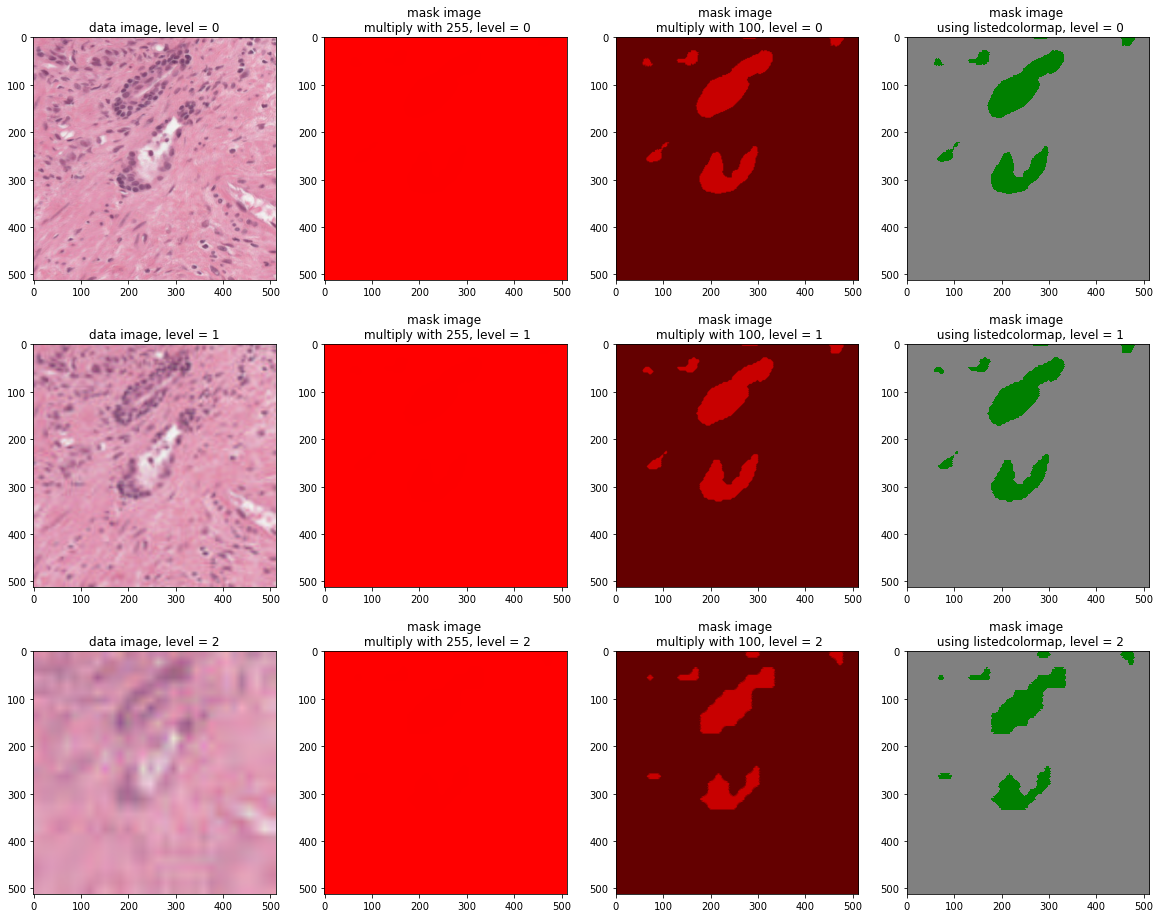

In [6]:
plt.figure(figsize = (20, 16))
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

for lv in [0, 1, 2]:
    %time a, b = load_data_and_mask(df[100][0], df[100][1:], lv)
    a.shape, b.shape
    plt.subplot(3,4,4*lv + 1), plt.imshow(a), plt.title('data image, level = %s'%(lv))
    plt.subplot(3,4,4*lv + 2), plt.imshow(b*255), plt.title('mask image \n multiply with 255, level = %s'%(lv))
    plt.subplot(3,4,4*lv + 3), plt.imshow(b*100), plt.title('mask image \n multiply with 100, level = %s'%(lv))
    plt.subplot(3,4,4*lv + 4), plt.imshow(b[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
    plt.title('mask image \n using listedcolormap, level = %s'%(lv))
plt.show()

del a, b

In [7]:
from torch.utils.data import Dataset, DataLoader
import torch

class PANDADataset(Dataset):
    def __init__(self, df, level = 2, transform=None):
        self.df = df
        self.level = level
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index, level = 2):
        ID = self.df[index][0]
        coordinate = self.df[index][1: ]
        image, mask = load_data_and_mask(ID, coordinate, level)
        
        return torch.tensor(image).permute(2, 0, 1), torch.tensor(mask).permute(2, 0, 1)[0]
    
cls = PANDADataset(df[:60000], 2)
%time cls[0][0].size(), cls[0][1].size(), len(cls)

CPU times: user 74.2 ms, sys: 10.7 ms, total: 84.9 ms
Wall time: 112 ms


(torch.Size([3, 512, 512]), torch.Size([512, 512]), 60000)

In [8]:
dataLoader = DataLoader(cls, batch_size=6, shuffle=True, num_workers=6)

def test_load():
    for i_batch, data in enumerate(dataLoader):
        inputs, labels = data
        print(i_batch, ': \t', inputs.size(), ', ', labels.size())
        del inputs, labels
        if i_batch == 6:
            break
%time test_load(); del df, cls

0 : 	 torch.Size([6, 3, 512, 512]) ,  torch.Size([6, 512, 512])
1 : 	 torch.Size([6, 3, 512, 512]) ,  torch.Size([6, 512, 512])
2 : 	 torch.Size([6, 3, 512, 512]) ,  torch.Size([6, 512, 512])
3 : 	 torch.Size([6, 3, 512, 512]) ,  torch.Size([6, 512, 512])
4 : 	 torch.Size([6, 3, 512, 512]) ,  torch.Size([6, 512, 512])
5 : 	 torch.Size([6, 3, 512, 512]) ,  torch.Size([6, 512, 512])
6 : 	 torch.Size([6, 3, 512, 512]) ,  torch.Size([6, 512, 512])
CPU times: user 70.2 ms, sys: 93.6 ms, total: 164 ms
Wall time: 2.57 s


In [9]:
# Adapted from https://discuss.pytorch.org/t/unet-implementation/426

import torch
from torch import nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=5, wf=6, padding=False,
                 batch_norm=False, up_mode='upconv'):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(UNetConvBlock(prev_channels, 2**(wf+i),
                                                padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, 2**(wf+i), up_mode,
                                            padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path)-1:
                blocks.append(x)
                x = F.avg_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i-1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                                    nn.Conv2d(in_size, out_size, kernel_size=1))

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

In [10]:
# --- unet params
#these parameters get fed directly into the UNET class, and more description of them can be discovered there

n_classes= 6    #number of classes in the data mask that we'll aim to predict


in_channels= 3  #input channel of the data, RGB = 3
padding= True   #should levels be padded
depth= 5       #depth of the network 
wf= 2           #wf (int): number of filters in the first layer is 2**wf, was 6
up_mode= 'upconv' #should we simply upsample the mask, or should we try and learn an interpolation 
batch_norm = True #should we use batch normalization between the layers

# --- training params
batch_size = 6
patch_size = 512
num_epochs = 15
edge_weight = 1.1 #edges tend to be the most poorly segmented given how little area they occupy in the training set, this paramter boosts their values along the lines of the original UNET paper
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch

In [11]:
gpuid=0
#specify if we should use a GPU (cuda) or only the CPU
if(torch.cuda.is_available()):
    print(torch.cuda.get_device_properties(gpuid))
    torch.cuda.set_device(gpuid)
    device = torch.device(f'cuda:{gpuid}')
else:
    device = torch.device(f'cpu')

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [12]:
#build the model according to the paramters specified above and copy it to the GPU. finally print out the number of trainable parameters
model = UNet(n_classes=n_classes, in_channels=in_channels, 
             padding=padding,depth=depth,wf=wf, 
             up_mode=up_mode, batch_norm=batch_norm).to(device)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

optim = torch.optim.Adam(model.parameters()) #adam is going to be the most robust
criterion = nn.CrossEntropyLoss(reduce=False)

total params: 	122486


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [13]:
import time
print('======================================== Training started ========================================')
for epoch in range(num_epochs):
    print('==================================================================================================')
    #model.train()  # Set model to training mode
    running_loss = 0.0
    t0 = time.time()
    for i, data in enumerate(dataLoader, 0):
        inputs, labels = data
        inputs = inputs.to(device,dtype=torch.float) 
        labels = labels.type('torch.LongTensor').to(device)
        ##with torch.set_grad_enabled(True):
        # zero the parameter gradients
        optim.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.sum().backward()
        optim.step()
        # print statistics
        
        running_loss += loss.mean()
        
        if i % 400 == 399:    # print every 400 mini-batches
            t1 = time.time()
            print('Epoch %02d, upto %05d mini-batches; after %02d (minutes) and %02d (seconds);  train_loss = %.3f'%
                  (epoch + 1, i + 1, (t1 - t0) // 60, (t1 - t0)%60, running_loss / 400))
            running_loss = 0.0
print('==================================================================================================')
print('======================================== Finished Training =======================================')

======================================== Training started ========================================
Epoch 01, upto 00400 mini-batches; after 01 (minutes) and 09 (seconds);  train_loss = 1.599
Epoch 01, upto 00800 mini-batches; after 02 (minutes) and 12 (seconds);  train_loss = 1.130
Epoch 01, upto 01200 mini-batches; after 03 (minutes) and 15 (seconds);  train_loss = 1.099
Epoch 01, upto 01600 mini-batches; after 04 (minutes) and 18 (seconds);  train_loss = 1.059
Epoch 01, upto 02000 mini-batches; after 05 (minutes) and 20 (seconds);  train_loss = 1.030
Epoch 01, upto 02400 mini-batches; after 06 (minutes) and 22 (seconds);  train_loss = 1.056
Epoch 01, upto 02800 mini-batches; after 07 (minutes) and 25 (seconds);  train_loss = 1.033
Epoch 01, upto 03200 mini-batches; after 08 (minutes) and 29 (seconds);  train_loss = 1.035
Epoch 01, upto 03600 mini-batches; after 09 (minutes) and 32 (seconds);  train_loss = 1.024
Epoch 01, upto 04000 mini-batches; after 10 (minutes) and 34 (seconds);  

Epoch 04, upto 04000 mini-batches; after 10 (minutes) and 50 (seconds);  train_loss = 0.881
Epoch 04, upto 04400 mini-batches; after 11 (minutes) and 55 (seconds);  train_loss = 0.866
Epoch 04, upto 04800 mini-batches; after 13 (minutes) and 00 (seconds);  train_loss = 0.849
Epoch 04, upto 05200 mini-batches; after 14 (minutes) and 05 (seconds);  train_loss = 0.871
Epoch 04, upto 05600 mini-batches; after 15 (minutes) and 10 (seconds);  train_loss = 0.860
Epoch 04, upto 06000 mini-batches; after 16 (minutes) and 14 (seconds);  train_loss = 0.865
Epoch 04, upto 06400 mini-batches; after 17 (minutes) and 19 (seconds);  train_loss = 0.849
Epoch 04, upto 06800 mini-batches; after 18 (minutes) and 24 (seconds);  train_loss = 0.865
Epoch 04, upto 07200 mini-batches; after 19 (minutes) and 27 (seconds);  train_loss = 0.843
Epoch 04, upto 07600 mini-batches; after 20 (minutes) and 32 (seconds);  train_loss = 0.874
Epoch 04, upto 08000 mini-batches; after 21 (minutes) and 36 (seconds);  train_l

Epoch 07, upto 08400 mini-batches; after 22 (minutes) and 33 (seconds);  train_loss = 0.855
Epoch 07, upto 08800 mini-batches; after 23 (minutes) and 37 (seconds);  train_loss = 0.836
Epoch 07, upto 09200 mini-batches; after 24 (minutes) and 41 (seconds);  train_loss = 0.821
Epoch 07, upto 09600 mini-batches; after 25 (minutes) and 46 (seconds);  train_loss = 0.860
Epoch 07, upto 10000 mini-batches; after 26 (minutes) and 49 (seconds);  train_loss = 0.829
Epoch 08, upto 00400 mini-batches; after 01 (minutes) and 05 (seconds);  train_loss = 0.867
Epoch 08, upto 00800 mini-batches; after 02 (minutes) and 09 (seconds);  train_loss = 0.818
Epoch 08, upto 01200 mini-batches; after 03 (minutes) and 13 (seconds);  train_loss = 0.843
Epoch 08, upto 01600 mini-batches; after 04 (minutes) and 18 (seconds);  train_loss = 0.843
Epoch 08, upto 02000 mini-batches; after 05 (minutes) and 21 (seconds);  train_loss = 0.814
Epoch 08, upto 02400 mini-batches; after 06 (minutes) and 26 (seconds);  train_l

Epoch 11, upto 02400 mini-batches; after 06 (minutes) and 22 (seconds);  train_loss = 0.817
Epoch 11, upto 02800 mini-batches; after 07 (minutes) and 26 (seconds);  train_loss = 0.822
Epoch 11, upto 03200 mini-batches; after 08 (minutes) and 28 (seconds);  train_loss = 0.840
Epoch 11, upto 03600 mini-batches; after 09 (minutes) and 31 (seconds);  train_loss = 0.834
Epoch 11, upto 04000 mini-batches; after 10 (minutes) and 34 (seconds);  train_loss = 0.825
Epoch 11, upto 04400 mini-batches; after 11 (minutes) and 36 (seconds);  train_loss = 0.839
Epoch 11, upto 04800 mini-batches; after 12 (minutes) and 39 (seconds);  train_loss = 0.840
Epoch 11, upto 05200 mini-batches; after 13 (minutes) and 42 (seconds);  train_loss = 0.842
Epoch 11, upto 05600 mini-batches; after 14 (minutes) and 45 (seconds);  train_loss = 0.827
Epoch 11, upto 06000 mini-batches; after 15 (minutes) and 48 (seconds);  train_loss = 0.824
Epoch 11, upto 06400 mini-batches; after 16 (minutes) and 50 (seconds);  train_l

Epoch 14, upto 06800 mini-batches; after 17 (minutes) and 52 (seconds);  train_loss = 0.803
Epoch 14, upto 07200 mini-batches; after 18 (minutes) and 56 (seconds);  train_loss = 0.821
Epoch 14, upto 07600 mini-batches; after 19 (minutes) and 57 (seconds);  train_loss = 0.821
Epoch 14, upto 08000 mini-batches; after 21 (minutes) and 00 (seconds);  train_loss = 0.803
Epoch 14, upto 08400 mini-batches; after 22 (minutes) and 03 (seconds);  train_loss = 0.801
Epoch 14, upto 08800 mini-batches; after 23 (minutes) and 06 (seconds);  train_loss = 0.799
Epoch 14, upto 09200 mini-batches; after 24 (minutes) and 07 (seconds);  train_loss = 0.814
Epoch 14, upto 09600 mini-batches; after 25 (minutes) and 10 (seconds);  train_loss = 0.799
Epoch 14, upto 10000 mini-batches; after 26 (minutes) and 12 (seconds);  train_loss = 0.809
Epoch 15, upto 00400 mini-batches; after 01 (minutes) and 04 (seconds);  train_loss = 0.817
Epoch 15, upto 00800 mini-batches; after 02 (minutes) and 08 (seconds);  train_l

In [14]:
## 60000 tiles ==> 11.6 to 12.2 Gb